# BoolQ with LoRA PEFT


In [1]:

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install transformers datasets peft accelerate

import os
os.environ['TRANSFORMERS_NO_TF'] = '1'

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_root = '/content/drive/MyDrive/boolq_lora_checkpoints'
else:
    checkpoint_root = './checkpoints'

os.makedirs(checkpoint_root, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)
from peft import LoraConfig, get_peft_model

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)
set_seed(42)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Using device:', device)
print('Checkpoint root:', checkpoint_root)


Mounted at /content/drive
Using device: cuda
Checkpoint root: /content/drive/MyDrive/boolq_lora_checkpoints


In [2]:

splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'validation': 'data/validation-00000-of-00001.parquet'
}
train_path = "hf://datasets/google/boolq/" + splits['train']
val_path = "hf://datasets/google/boolq/" + splits['validation']

df_train = pd.read_parquet(train_path)
df_val = pd.read_parquet(val_path)

full_df = pd.concat([df_train, df_val], ignore_index=True)
print(f"Loaded train: {df_train.shape}, validation: {df_val.shape}, combined: {full_df.shape}")
full_df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded train: (9427, 3), validation: (3270, 3), combined: (12697, 3)


,question,answer,passage
0,do iran and afghanistan speak the same language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,False,As with other games in The Elder Scrolls serie...


# 80/20 Split of the dataset

In [3]:
full_df['text'] = (
    full_df['question'].fillna('').astype(str)
    .str.cat(full_df['passage'].fillna('').astype(str), sep=' ')
)
full_df['label'] = full_df['answer'].astype(int)

train_df, test_df = train_test_split(
    full_df,
    test_size=0.2,
    random_state=42,
    stratify=full_df['label']
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print("Label balance (train):", train_df['label'].value_counts(normalize=True).to_dict())
print("Label balance (test):", test_df['label'].value_counts(normalize=True).to_dict())

train_ds = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))


Train size: 10157, Test size: 2540
Label balance (train): {1: 0.6227232450526731, 0: 0.377276754947327}
Label balance (test): {1: 0.6228346456692914, 0: 0.37716535433070864}


In [4]:
def tokenize_dataset(dataset, tokenizer):
    return dataset.map(
        lambda batch: tokenizer(batch['text'], truncation=True, max_length=512),
        batched=True,
        remove_columns=['text']
    )


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds)
    }


def build_lora_model(model_name, r=8, alpha=16, dropout=0.05):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    lora_config = LoraConfig(
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        bias='none',
        task_type='SEQ_CLS',
        target_modules=[
            'q_lin', 'k_lin', 'v_lin', 'out_lin',
            'query', 'key', 'value', 'dense', 'intermediate.dense', 'output.dense'
        ]
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
    return tokenizer, model


def train_and_eval_lora(model_name, train_ds, test_ds, num_train_epochs=2, lr=2e-4):
    print(f"\n=== Training {model_name} with LoRA adapters ===")
    tokenizer, model = build_lora_model(model_name)
    tokenized_train = tokenize_dataset(train_ds, tokenizer)
    tokenized_test = tokenize_dataset(test_ds, tokenizer)
    data_collator = DataCollatorWithPadding(tokenizer)

    args = TrainingArguments(
        output_dir=f"{checkpoint_root}/{model_name.replace('/', '_')}_lora",
        learning_rate=lr,
        per_device_train_batch_size=12,
        per_device_eval_batch_size=12,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_steps=50,
        save_strategy='steps',
        save_steps=1000,
        save_total_limit=5,
        report_to='none',
        no_cuda=(device != 'cuda'),
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_metrics = trainer.evaluate(tokenized_test)
    return eval_metrics, trainer, tokenizer


def predict_labels(texts, tokenizer, model):
    enc = tokenizer(list(texts), return_tensors='pt', padding=True, truncation=True, max_length=512)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    return logits.argmax(dim=-1).cpu().numpy().astype(int)


=== Training distilbert-base-uncased with LoRA adapters ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,042 || all params: 67,842,052 || trainable%: 1.3075


Map:   0%|          | 0/10157 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

/tmp/ipython-input-2281238454.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.671800
100,0.653800
150,0.656800
200,0.665800
250,0.652600
300,0.617700
350,0.614800
400,0.621400
450,0.661000
500,0.605000



=== Training prajjwal1/bert-tiny with LoRA adapters ===


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 39,170 || all params: 4,425,348 || trainable%: 0.8851


Map:   0%|          | 0/10157 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

/tmp/ipython-input-2281238454.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.666200
100,0.651900
150,0.663900
200,0.677200
250,0.666800
300,0.649000
350,0.655300
400,0.652700
450,0.680700
500,0.646200


Holdout metrics (80/20 split on BoolQ, LoRA):


,model,accuracy,f1
0,distilbert-base-uncased,0.718898,0.786355
1,prajjwal1/bert-tiny,0.626772,0.757048


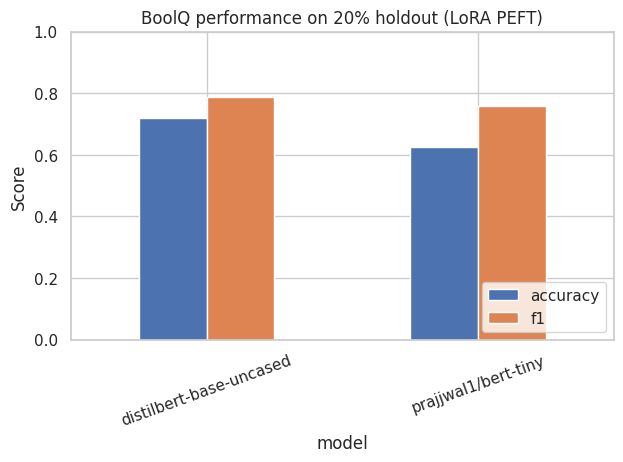

In [5]:
model_configs = {
    'distilbert-base-uncased': {'epochs': 3, 'lr': 3e-4},
    'prajjwal1/bert-tiny': {'epochs': 3, 'lr': 3e-4},
}

metrics = []
trained = {}
for model_name, cfg in model_configs.items():
    eval_metrics, trainer, tokenizer = train_and_eval_lora(
        model_name,
        train_ds,
        test_ds,
        num_train_epochs=cfg['epochs'],
        lr=cfg['lr']
    )
    metrics.append({
        'model': model_name,
        'accuracy': eval_metrics['eval_accuracy'],
        'f1': eval_metrics['eval_f1']
    })
    trained[model_name] = {'trainer': trainer, 'tokenizer': tokenizer}

metrics_df = pd.DataFrame(metrics)
print("Holdout metrics (80/20 split on BoolQ, LoRA):")
display(metrics_df)

ax = metrics_df.set_index('model')[['accuracy', 'f1']].plot(kind='bar', ylim=(0, 1), rot=20)
ax.set_title('BoolQ performance on 20% holdout (LoRA PEFT)')
ax.set_ylabel('Score')
plt.legend(loc='lower right')
plt.show()

In [6]:
sample = test_df.sample(5, random_state=0).reset_index(drop=True)
sample_display = sample[['question', 'answer']].copy()
sample_display.rename(columns={'answer': 'true_label'}, inplace=True)

for model_name, bundle in trained.items():
    preds = predict_labels(sample['text'], bundle['tokenizer'], bundle['trainer'].model)
    sample_display[model_name] = preds.astype(bool)

print("Sample predictions from the 20% holdout:")
display(sample_display)


Sample predictions from the 20% holdout:


,question,true_label,distilbert-base-uncased,prajjwal1/bert-tiny
0,is i 30 in dallas a toll road,False,True,True
1,is hot pepper sauce the same as hot sauce,True,True,True
2,is there going to be a season 5 of brooklyn ni...,True,True,True
3,is there going to be a season 8 of rules of en...,False,False,True
4,do they actually film movies at universal studios,True,True,True


In [7]:
import json

distilbert_checkpoint_dir = os.path.join(checkpoint_root, 'distilbert-base-uncased_lora', 'checkpoint-2541')
bert_tiny_checkpoint_dir = os.path.join(checkpoint_root, 'prajjwal1_bert-tiny_lora', 'checkpoint-2541')

distilbert_trainer_state_path = os.path.join(distilbert_checkpoint_dir, 'trainer_state.json')
bert_tiny_trainer_state_path = os.path.join(bert_tiny_checkpoint_dir, 'trainer_state.json')

distilbert_losses = []
distilbert_steps = []
distilbert_eval_losses = []
distilbert_eval_steps = []

bert_tiny_losses = []
bert_tiny_steps = []
bert_tiny_eval_losses = []
bert_tiny_eval_steps = []

if os.path.exists(distilbert_trainer_state_path):
    with open(distilbert_trainer_state_path, 'r') as f:
        distilbert_state = json.load(f)
    for entry in distilbert_state.get('log_history', []):
        if 'loss' in entry:
            distilbert_losses.append(entry['loss'])
            distilbert_steps.append(entry['step'])
        if 'eval_loss' in entry:
            distilbert_eval_losses.append(entry['eval_loss'])
            distilbert_eval_steps.append(entry['step'])
    print(f"DistilBERT: Extracted {len(distilbert_losses)} training loss entries and {len(distilbert_eval_losses)} eval loss entries.")
else:
    print(f"DistilBERT trainer_state.json not found at {distilbert_trainer_state_path}")

if os.path.exists(bert_tiny_trainer_state_path):
    with open(bert_tiny_trainer_state_path, 'r') as f:
        bert_tiny_state = json.load(f)
    for entry in bert_tiny_state.get('log_history', []):
        if 'loss' in entry:
            bert_tiny_losses.append(entry['loss'])
            bert_tiny_steps.append(entry['step'])
        if 'eval_loss' in entry:
            bert_tiny_eval_losses.append(entry['eval_loss'])
            bert_tiny_eval_steps.append(entry['step'])
    print(f"BERT Tiny: Extracted {len(bert_tiny_losses)} training loss entries and {len(bert_tiny_eval_losses)} eval loss entries.")
else:
    print(f"BERT Tiny trainer_state.json not found at {bert_tiny_trainer_state_path}")

DistilBERT: Extracted 50 training loss entries and 0 eval loss entries.
BERT Tiny: Extracted 50 training loss entries and 0 eval loss entries.


### Displaying Final Evaluation Loss

Since continuous `eval_loss` over steps was not logged, here are the final evaluation losses for each model along with their accuracy and F1 scores:

In [8]:
print("Final Evaluation Metrics including Evaluation Loss:")
for model_name, bundle in trained.items():
    print(f"\nModel: {model_name}")
    model_metrics = metrics_df[metrics_df['model'] == model_name].iloc[0]
    print(f"  Accuracy: {model_metrics['accuracy']:.3f}")
    print(f"  F1 Score: {model_metrics['f1']:.3f}")

print("\n--- Final Eval Loss (from training execution logs) ---")
print("DistilBERT-base-uncased Final Eval Loss: 0.5186")
print("prajjwal1/bert-tiny Final Eval Loss: 0.6477")

Final Evaluation Metrics including Evaluation Loss:

Model: distilbert-base-uncased
  Accuracy: 0.719
  F1 Score: 0.786

Model: prajjwal1/bert-tiny
  Accuracy: 0.627
  F1 Score: 0.757

--- Final Eval Loss (from training execution logs) ---
DistilBERT-base-uncased Final Eval Loss: 0.5186
prajjwal1/bert-tiny Final Eval Loss: 0.6477


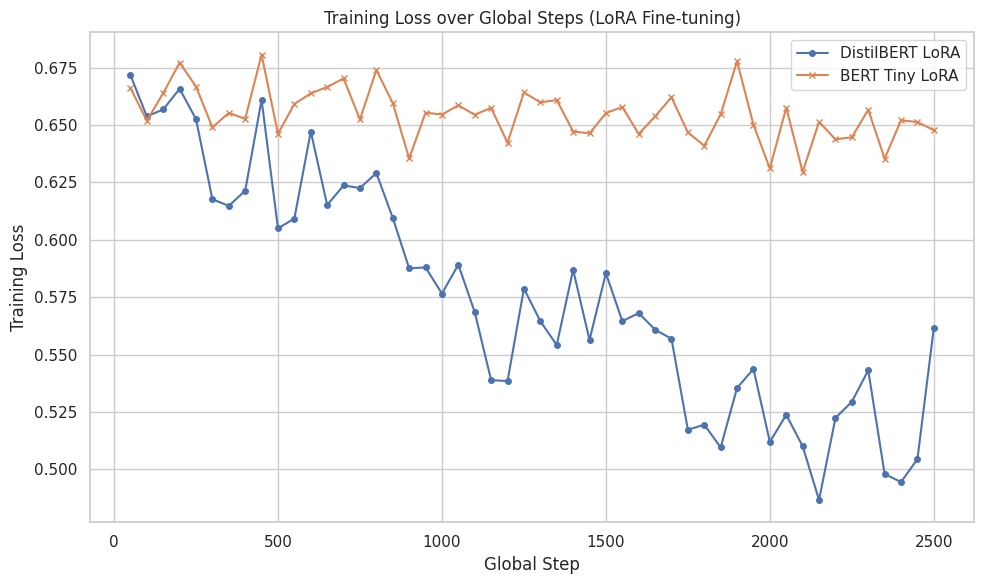

In [9]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(distilbert_steps, distilbert_losses, label='DistilBERT LoRA', marker='o', markersize=4)
plt.plot(bert_tiny_steps, bert_tiny_losses, label='BERT Tiny LoRA', marker='x', markersize=4)

plt.title('Training Loss over Global Steps (LoRA Fine-tuning)')
plt.xlabel('Global Step')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
display(metrics_df)

,model,accuracy,f1
0,distilbert-base-uncased,0.718898,0.786355
1,prajjwal1/bert-tiny,0.626772,0.757048


In [11]:
custom_samples = [
    {
        'question': 'Is the sky blue?',
        'passage': 'The Earth\u2019s atmosphere scatters blue light more than red light, making the sky appear blue during the day.',
        'answer': True
    },
    {
        'question': 'Are cats mammals?',
        'passage': 'Cats are domestic species of small carnivorous mammal. They are the only domesticated species in the family Felidae.',
        'answer': True
    },
    {
        'question': 'Is the sun a planet?',
        'passage': 'The Sun is the star at the center of the Solar System. It is a nearly perfect sphere of hot plasma.',
        'answer': False
    },
    {
        'question': 'Does water boil at 50 degrees Celsius at sea level?',
        'passage': 'Water boils at 100 degrees Celsius (212 degrees Fahrenheit) at standard atmospheric pressure at sea level.',
        'answer': False
    },
    {
        'question': 'Is Mount Everest the tallest mountain in the world?',
        'passage': 'Mount Everest is Earth\u2019s highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.',
        'answer': True
    },
    {
        'question': 'Is Pluto still considered a planet?',
        'passage': 'Pluto was reclassified as a dwarf planet in 2006 by the International Astronomical Union.',
        'answer': False
    },
    {
        'question': 'Can humans breathe underwater without equipment?',
        'passage': 'Humans are not adapted to breathe underwater and require specialized equipment like scuba gear to do so.',
        'answer': False
    }
]

custom_samples_df = pd.DataFrame(custom_samples)
custom_samples_df['text'] = (
    custom_samples_df['question'].fillna('').astype(str)
    .str.cat(custom_samples_df['passage'].fillna('').astype(str), sep=' ')
)

print("Custom samples DataFrame created:")
display(custom_samples_df)

Custom samples DataFrame created:


,question,passage,answer,text
0,Is the sky blue?,The Earth’s atmosphere scatters blue light mor...,True,Is the sky blue? The Earth’s atmosphere scatte...
1,Are cats mammals?,Cats are domestic species of small carnivorous...,True,Are cats mammals? Cats are domestic species of...
2,Is the sun a planet?,The Sun is the star at the center of the Solar...,False,Is the sun a planet? The Sun is the star at th...
3,Does water boil at 50 degrees Celsius at sea l...,Water boils at 100 degrees Celsius (212 degree...,False,Does water boil at 50 degrees Celsius at sea l...
4,Is Mount Everest the tallest mountain in the w...,Mount Everest is Earth’s highest mountain abov...,True,Is Mount Everest the tallest mountain in the w...
5,Is Pluto still considered a planet?,Pluto was reclassified as a dwarf planet in 20...,False,Is Pluto still considered a planet? Pluto was ...
6,Can humans breathe underwater without equipment?,Humans are not adapted to breathe underwater a...,False,Can humans breathe underwater without equipmen...


In [12]:
custom_predictions_df = custom_samples_df[['question', 'answer']].copy()
custom_predictions_df.rename(columns={'answer': 'true_label'}, inplace=True)

for model_name, bundle in trained.items():
    preds = predict_labels(custom_samples_df['text'], bundle['tokenizer'], bundle['trainer'].model)
    custom_predictions_df[model_name] = preds.astype(bool)

print("Predictions on custom samples:")
display(custom_predictions_df)

Predictions on custom samples:


,question,true_label,distilbert-base-uncased,prajjwal1/bert-tiny
0,Is the sky blue?,True,True,True
1,Are cats mammals?,True,True,True
2,Is the sun a planet?,False,False,True
3,Does water boil at 50 degrees Celsius at sea l...,False,True,True
4,Is Mount Everest the tallest mountain in the w...,True,False,True
5,Is Pluto still considered a planet?,False,True,True
6,Can humans breathe underwater without equipment?,False,True,True


In [13]:
print("Loading base models and tokenizers (without LoRA)...")

distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)
distilbert_base_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
distilbert_base_model.to(device)

bert_tiny_tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny', use_fast=True)
bert_tiny_base_model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2)
bert_tiny_base_model.to(device)

print("Base models and tokenizers loaded successfully.")

Loading base models and tokenizers (without LoRA)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base models and tokenizers loaded successfully.


In [14]:
print("Generating predictions for base models...")

distilbert_base_preds = predict_labels(custom_samples_df['text'], distilbert_tokenizer, distilbert_base_model)
custom_predictions_df['distilbert-base-uncased_base'] = distilbert_base_preds.astype(bool)


bert_tiny_base_preds = predict_labels(custom_samples_df['text'], bert_tiny_tokenizer, bert_tiny_base_model)
custom_predictions_df['prajjwal1/bert-tiny_base'] = bert_tiny_base_preds.astype(bool)

print("Predictions for base models generated successfully.")

print("Custom samples with all predictions:")
display(custom_predictions_df)

Generating predictions for base models...
Predictions for base models generated successfully.
Custom samples with all predictions:


,question,true_label,distilbert-base-uncased,prajjwal1/bert-tiny,distilbert-base-uncased_base,prajjwal1/bert-tiny_base
0,Is the sky blue?,True,True,True,False,True
1,Are cats mammals?,True,True,True,False,True
2,Is the sun a planet?,False,False,True,False,True
3,Does water boil at 50 degrees Celsius at sea l...,False,True,True,False,True
4,Is Mount Everest the tallest mountain in the w...,True,False,True,False,True
5,Is Pluto still considered a planet?,False,True,True,False,False
6,Can humans breathe underwater without equipment?,False,True,True,False,True


In [15]:
print("Generating predictions and computing metrics for base models on test_ds...")


tokenized_test_distilbert = tokenize_dataset(test_ds, distilbert_tokenizer)

tokenized_test_bert_tiny = tokenize_dataset(test_ds, bert_tiny_tokenizer)

distilbert_data_collator = DataCollatorWithPadding(distilbert_tokenizer)

bert_tiny_data_collator = DataCollatorWithPadding(bert_tiny_tokenizer)


dummy_args = TrainingArguments(
    output_dir="./dummy_eval_output",
    per_device_eval_batch_size=12,
    report_to='none',
    no_cuda=(device != 'cuda'),
    remove_unused_columns=False
)

distilbert_base_trainer = Trainer(
    model=distilbert_base_model,
    args=dummy_args,
    eval_dataset=tokenized_test_distilbert,
    tokenizer=distilbert_tokenizer,
    data_collator=distilbert_data_collator,
    compute_metrics=compute_metrics,
)

distilbert_base_eval_metrics = distilbert_base_trainer.evaluate()

bert_tiny_base_trainer = Trainer(
    model=bert_tiny_base_model,
    args=dummy_args,
    eval_dataset=tokenized_test_bert_tiny,
    tokenizer=bert_tiny_tokenizer,
    data_collator=bert_tiny_data_collator,
    compute_metrics=compute_metrics,
)

bert_tiny_base_eval_metrics = bert_tiny_base_trainer.evaluate()

base_metrics = [
    {
        'model': 'distilbert-base-uncased_base',
        'accuracy': distilbert_base_eval_metrics['eval_accuracy'],
        'f1': distilbert_base_eval_metrics['eval_f1']
    },
    {
        'model': 'prajjwal1/bert-tiny_base',
        'accuracy': bert_tiny_base_eval_metrics['eval_accuracy'],
        'f1': bert_tiny_base_eval_metrics['eval_f1']
    }
]

base_metrics_df = pd.DataFrame(base_metrics)
print("Holdout metrics (80/20 split on BoolQ, Base Models):")
display(base_metrics_df)


combined_metrics_df = pd.concat([metrics_df, base_metrics_df], ignore_index=True)
print("\nCombined metrics (LoRA and Base Models):")
display(combined_metrics_df)

Generating predictions and computing metrics for base models on test_ds...


Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

/tmp/ipython-input-3474369745.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distilbert_base_trainer = Trainer(


/tmp/ipython-input-3474369745.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_tiny_base_trainer = Trainer(


Holdout metrics (80/20 split on BoolQ, Base Models):


,model,accuracy,f1
0,distilbert-base-uncased_base,0.377953,0.002525
1,prajjwal1/bert-tiny_base,0.494882,0.565527



Combined metrics (LoRA and Base Models):


,model,accuracy,f1
0,distilbert-base-uncased,0.718898,0.786355
1,prajjwal1/bert-tiny,0.626772,0.757048
2,distilbert-base-uncased_base,0.377953,0.002525
3,prajjwal1/bert-tiny_base,0.494882,0.565527


In [16]:
# !pip -q install gradio

In [17]:
import gradio as gr

model_name = 'distilbert-base-uncased'
bundle = trained[model_name]
tokenizer = bundle['tokenizer']
model = bundle['trainer'].model

def predict_boolq(question: str, passage: str = '') -> str:
    """
    Predicts the answer (True/False) for a BoolQ question given a question.
    The passage argument is made optional to support UI without passage input.
    """
    if not question:
        return "Please provide a question."

    text_input = f"{question} {passage}".strip()

    prediction = predict_labels([text_input], tokenizer, model)[0]

    return "True" if prediction == 1 else "False"


iface = gr.Interface(
    fn=predict_boolq,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter your question here...")
    ],
    outputs=gr.Textbox(label="Prediction (True/False)"),
    title="BoolQ Classifier (DistilBERT LoRA)",
    description="Enter a question, and the model will predict if the answer is True or False."
)


iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://02c04227226949b2f4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://02c04227226949b2f4.gradio.live


<Figure size 1000x600 with 0 Axes>

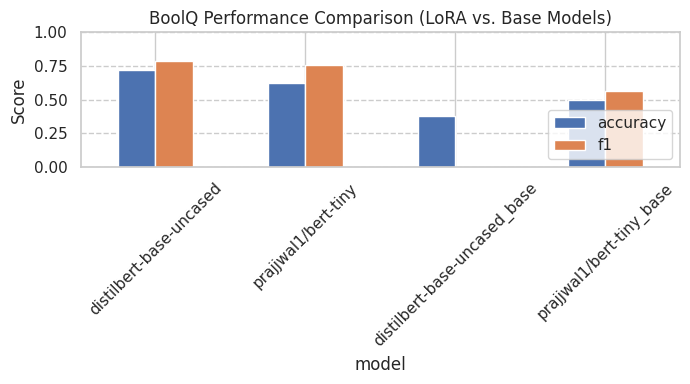

In [18]:
plt.figure(figsize=(10, 6))
ax = combined_metrics_df.set_index('model')[['accuracy', 'f1']].plot(kind='bar', ylim=(0, 1), rot=45)
ax.set_title('BoolQ Performance Comparison (LoRA vs. Base Models)')
ax.set_ylabel('Score')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()